In [1]:
!pip3 install pandas scikit-learn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# Data preprocessing

In [2]:
from itertools import cycle
import pickle
import sys
import time
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization, Convolution1D, MaxPooling1D, Reshape

%matplotlib inline

In [3]:
data = pd.read_csv('../dataset/web_attacks_balanced.csv', delimiter=',')

y = data['Label']
x = data.drop(labels=['Label', 'Flow ID', 'Source IP', 'Source Port',
              'Destination IP', 'Destination Port', 'Protocol', 'Timestamp'], axis=1)

## Preparing feature vectors for training

First, we need to inspect feature vectors.

In [4]:
x

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,350.0,4.0,4.0,116.0,116.0,29.0,29.0,29.0,0.000000,29.0,...,3.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,203.0,2.0,2.0,88.0,188.0,44.0,44.0,44.0,0.000000,94.0,...,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,2.0,0.0,7.0,0.0,7.0,0.0,3.5,4.949747,0.0,...,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,204.0,2.0,2.0,88.0,188.0,44.0,44.0,44.0,0.000000,94.0,...,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,169.0,2.0,2.0,102.0,224.0,51.0,51.0,51.0,0.000000,112.0,...,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,23697.0,1.0,1.0,45.0,61.0,45.0,45.0,45.0,0.000000,61.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7263,19359.0,3.0,0.0,18.0,0.0,6.0,6.0,6.0,0.000000,0.0,...,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7264,169.0,2.0,2.0,60.0,264.0,30.0,30.0,30.0,0.000000,132.0,...,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7265,2.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.000000,0.0,...,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Check the absence of missing values in feature vectors.

In [5]:
x.isnull().values.any()

False

As we can see, the range of features is not normalized. We need to perform feature scaling for the correct functioning of selected deep learning algorithms (CNN and BiLSTM).

In our case, the min-max normalization is used: all selected features are transformed into the range [0, 1].

In [6]:
scaler = sklearn.preprocessing.MinMaxScaler()

In [7]:
x = scaler.fit_transform(x)
x

array([[2.92513451e-06, 7.02082846e-04, 6.14533723e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.70007818e-06, 2.34027615e-04, 3.07266861e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.66674331e-08, 2.34027615e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.41673181e-06, 2.34027615e-04, 3.07266861e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.50011496e-08, 2.34027615e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.93625570e-04, 0.00000000e+00, 1.53633431e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

To prevent data leakage, feature scaling would be performed on cross-validation folds at the training step.

### Preparing labels for training

First, we need to inspect labels.

In [8]:
y

0       BENIGN
1       BENIGN
2       BENIGN
3       BENIGN
4       BENIGN
         ...  
7262    BENIGN
7263    BENIGN
7264    BENIGN
7265    BENIGN
7266    BENIGN
Name: Label, Length: 7267, dtype: object

In [9]:
y.unique()

array(['BENIGN', 'Web Attack – Brute Force', 'Web Attack – XSS',
       'Web Attack – Sql Injection'], dtype=object)

In [10]:
y.value_counts()

Label
BENIGN                        5087
Web Attack – Brute Force      1507
Web Attack – XSS               652
Web Attack – Sql Injection      21
Name: count, dtype: int64

Check the absence of missing values in labels.

In [11]:
y.isnull().values.any()

False

In [12]:
y_encoded = pd.get_dummies(y).values
y_encoded

array([[ True, False, False, False],
       [ True, False, False, False],
       [ True, False, False, False],
       ...,
       [ True, False, False, False],
       [ True, False, False, False],
       [ True, False, False, False]])

In [13]:
train_x, val_x, train_y, val_y = train_test_split(x, 
                                                  y_encoded, 
                                                  stratify=y, 
                                                  test_size=0.2)

In [14]:
print("train_x : ", train_x.shape)
print("val_x : ", val_x.shape)
print("train_y : ", train_y.shape)
print("val_y : ", val_y.shape)

train_x :  (5813, 76)
val_x :  (1454, 76)
train_y :  (5813, 4)
val_y :  (1454, 4)


## create tf Dataset

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(buffer_size=100000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(32)

# The neural network preparation

In [16]:
def CNN_BiLSTM():
    model = tf.keras.Sequential()
    model.add(Convolution1D(64, kernel_size=32, padding="same",
              activation="relu", input_shape=(76, 1)))
    model.add(MaxPooling1D(pool_size=(5)))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Reshape((128, 1), input_shape=(128, )))

    model.add(MaxPooling1D(pool_size=(5)))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(128, return_sequences=False)))

    model.add(Dropout(0.5))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [17]:
packet_class = CNN_BiLSTM()
packet_class.summary(line_length=100)

Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv1d (Conv1D)                             (None, 76, 64)                          2112           
                                                                                                    
 max_pooling1d (MaxPooling1D)                (None, 15, 64)                          0              
                                                                                                    
 batch_normalization (BatchNormalization)    (None, 15, 64)                          256            
                                                                                                    
 bidirectional (Bidirectional)               (None, 128)                             66048          
                                                                       

## The neural network training

In [18]:
save_path = './model/packet_class_all/'
checkpoint_path = save_path+"/model_{epoch}.ckpt"

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, period=1)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)

In [19]:
history = packet_class.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[cp_callback])

Epoch 1/30
182/182 [==============================] - 12s 30ms/step - loss: 0.3957 - accuracy: 0.8445 - val_loss: 0.7199 - val_accuracy: 0.7001
Epoch 2/30
182/182 [==============================] - 4s 23ms/step - loss: 0.3007 - accuracy: 0.8681 - val_loss: 0.9770 - val_accuracy: 0.6121
Epoch 3/30
182/182 [==============================] - 4s 22ms/step - loss: 0.2972 - accuracy: 0.8775 - val_loss: 0.3824 - val_accuracy: 0.8700
Epoch 4/30
182/182 [==============================] - 4s 24ms/step - loss: 0.2776 - accuracy: 0.8798 - val_loss: 0.2705 - val_accuracy: 0.8810
Epoch 5/30
182/182 [==============================] - 4s 23ms/step - loss: 0.3043 - accuracy: 0.8755 - val_loss: 0.3186 - val_accuracy: 0.8693
Epoch 6/30
182/182 [==============================] - 4s 24ms/step - loss: 0.2833 - accuracy: 0.8780 - val_loss: 0.3394 - val_accuracy: 0.8611
Epoch 7/30
182/182 [==============================] - 4s 22ms/step - loss: 0.3199 - accuracy: 0.8722 - val_loss: 0.3292 - val_accuracy: 0.855

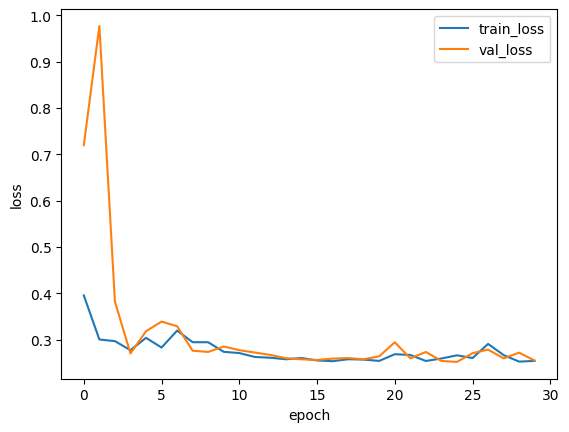

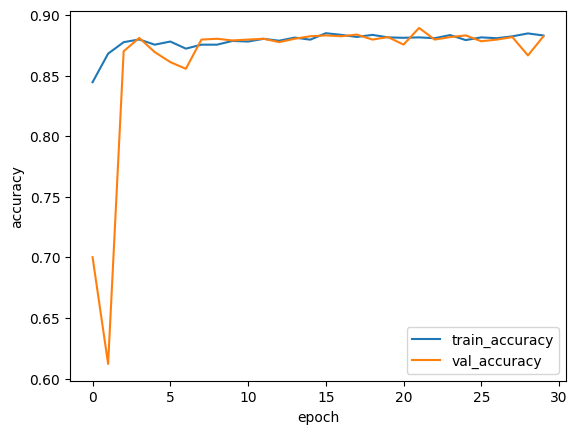

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

# predict

In [21]:
epoch = 30
checkpoint_path = f"./model/packet_class_all/model_{epoch}.ckpt"

packet_class = CNN_BiLSTM()
packet_class.load_weights(checkpoint_path)
packet_class.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 76, 64)            2112      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 15, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 15, 64)           256       
 hNormalization)                                                 
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 reshape_1 (Reshape)         (None, 128, 1)            0         
                                                      

In [22]:
loss, acc = packet_class.evaluate(val_dataset, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

46/46 [==============================] - 2s 13ms/step - loss: 0.2551 - accuracy: 0.8824
Restored model, accuracy: 88.24%
